### Section 1: Warm Up (1/4)



1. Which companies applied for the largest number of H­1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

2. Calculate the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?

3. For NYC, what is the relationship between the total number of H­1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?


In [1]:
import os
import sys
sys.path.append('src')
import seaborn as sns
import sklearn as sl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from misc import uni_wage
#from misc import generate_list
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
#plt.style.use('ggplot')
%matplotlib inline 


/Users/Henrilin28/.pyenv/versions/2.7.12/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Henrilin28/.pyenv/versions/2.7.12/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
H1B_data = pd.read_csv('data/enigma-h1b.csv')

In [3]:
H1B_data.isnull().shape

(519504, 36)

In [4]:
H1B_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519504 entries, 0 to 519503
Data columns (total 36 columns):
lca_case_number                   519504 non-null object
status                            519504 non-null object
lca_case_submit                   519504 non-null object
decision_date                     519504 non-null object
visa_class                        519504 non-null object
lca_case_employment_start_date    519500 non-null object
lca_case_employment_end_date      519499 non-null object
lca_case_employer_name            519476 non-null object
lca_case_employer_address         519462 non-null object
lca_case_employer_city            519477 non-null object
lca_case_employer_state           519458 non-null object
lca_case_employer_postal_code     519463 non-null object
lca_case_soc_code                 519455 non-null object
lca_case_soc_name                 515233 non-null object
lca_case_job_title                519497 non-null object
lca_case_wage_rate_from           

In [5]:
H1B_data.visa_class.unique()

array(['H-1B', 'H-1B1 Chile', 'H-1B1 Singapore', 'E-3 Australian'], dtype=object)

In [6]:
H1B_data = H1B_data.dropna(subset=["lca_case_employer_name"])

In [7]:
H1B_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519476 entries, 0 to 519503
Data columns (total 36 columns):
lca_case_number                   519476 non-null object
status                            519476 non-null object
lca_case_submit                   519476 non-null object
decision_date                     519476 non-null object
visa_class                        519476 non-null object
lca_case_employment_start_date    519474 non-null object
lca_case_employment_end_date      519473 non-null object
lca_case_employer_name            519476 non-null object
lca_case_employer_address         519462 non-null object
lca_case_employer_city            519473 non-null object
lca_case_employer_state           519449 non-null object
lca_case_employer_postal_code     519456 non-null object
lca_case_soc_code                 519428 non-null object
lca_case_soc_name                 515207 non-null object
lca_case_job_title                519471 non-null object
lca_case_wage_rate_from           

In [8]:
H1B_data = H1B_data[H1B_data.visa_class == "H-1B"]

In [9]:
H1B_data_NYC = H1B_data[H1B_data["lca_case_employer_city"] == "NEW YORK"]

In [10]:
# Total 26522 applications within New York City
print "Total Number of application in NYC: {}".format(len(H1B_data_NYC))

Total Number of application in NYC: 24002


#### Which companies applied for the largest number of H­1B visas where the job opening was located in NYC? Please describe any issues you may encounter summarizing the data by employer name.

The figure below shows that MPHASIS CORPORATION HAS THE LARGEST number of H-1B application in NYC. The issue I had was data on enigma and us gov is inconsistant. I tried three different sources to get the H-1B data.

1) Enigma export

2) Enigma API

3) US gov

for 1 and 3, the total number of application is the same but application in NYC in a little bit different. One is 26535, another is 26532. As for the API it only return 500 data in one page, I tried to get all the data but no clue with the encryption link




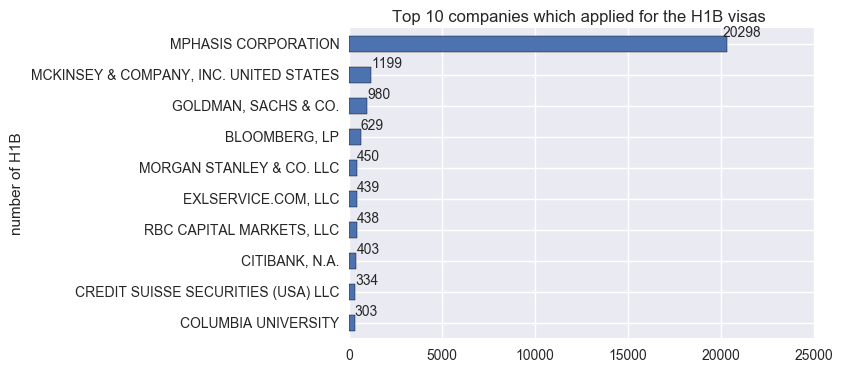

In [11]:
fig, ax = plt.subplots()
company_total_worker = pd.DataFrame([H1B_data_NYC["total_workers"],H1B_data_NYC["lca_case_employer_name"]]).T
company_rank = company_total_worker.groupby("lca_case_employer_name")["total_workers"].sum()

company_rank.sort_values(ascending=False)[:10].plot(ax=ax, kind="barh")
for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() * 0.99, p.get_y() * 1))
plt.title("Top 10 companies which applied for the H1B visas ")
plt.ylabel('number of H1B')
plt.gca().invert_yaxis()

### 2. Calculate the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? What factors could explain the results?

In [12]:
H1b_select = H1B_data[["lca_case_wage_rate_from",'lca_case_wage_rate_to','total_workers',
                       'lca_case_employer_name',"lca_case_employer_city","lca_case_wage_rate_unit"]]

In [13]:
attr_from = "lca_case_wage_rate_from"
attr_to = "lca_case_wage_rate_to"

In [14]:
H1B_data_MV = H1b_select[H1b_select["lca_case_employer_city"] == "MOUNTAIN VIEW"]

print "unique pay unit in H1B visa: {}".format(H1B_data_MV["lca_case_wage_rate_unit"].unique())
H1B_data_MV.groupby("lca_case_wage_rate_unit").size()

unique pay unit in H1B visa: ['Year' 'Hour' 'Month']


lca_case_wage_rate_unit
Hour       44
Month       3
Year     5138
dtype: int64

In [15]:
### here I unified the wage unit to year by applying uni_wage function (which is in misc.py)
### some pay in hour is too high (it might be true), so I tried to exclude them out of my sample

H1B_data_MV_test = H1B_data_MV.copy()
H1B_data_MV_test = H1B_data_MV_test[np.isfinite(H1B_data_MV_test[attr_from])]
H1B_data_MV_test_uni = uni_wage(H1B_data_MV_test)

wrong_unit: Hour, pay:127000.0
wrong_unit: Hour, pay:105000.0
wrong_unit: Hour, pay:105000.0
wrong_unit: Hour, pay:90000.0
5185 of application has been unified


In [16]:
MV_wage = pd.DataFrame(H1B_data_MV_test_uni.groupby('lca_case_wage_rate_from')["total_workers"].sum())
MV_wage = MV_wage.reset_index()

In [17]:
### There are some missing unit in the data. These kind of data is also excluded here
H1b_select_NYC = H1b_select[H1b_select["lca_case_employer_city"] == "NEW YORK"]
print "unique pay unit in H1B visa: {}".format(H1b_select_NYC["lca_case_wage_rate_unit"].unique())
H1b_select_NYC = H1b_select_NYC.dropna(subset=["lca_case_wage_rate_unit"])
print "unique pay unit in H1B visa: {}".format(H1b_select_NYC["lca_case_wage_rate_unit"].unique())
H1b_select_NYC.groupby("lca_case_wage_rate_unit").size()

unique pay unit in H1B visa: ['Year' 'Hour' nan 'Month' 'Bi-Weekly' 'Week']
unique pay unit in H1B visa: ['Year' 'Hour' 'Month' 'Bi-Weekly' 'Week']


lca_case_wage_rate_unit
Bi-Weekly        5
Hour          2518
Month           14
Week            12
Year         21452
dtype: int64

In [18]:
H1B_data_NYC_test_uni = uni_wage(H1b_select_NYC)

wrong_unit: Hour, pay:80000.0
wrong_unit: Hour, pay:65000.0
37230
wrong_unit: Hour, pay:70000.0
wrong_unit: Hour, pay:130000.0
wrong_unit: Hour, pay:115000.0
wrong_unit: Hour, pay:85000.0
wrong_unit: Hour, pay:55000.0
wrong_unit: Hour, pay:60000.0
89931
wrong_unit: Hour, pay:50150.0
wrong_unit: Hour, pay:64584.0
137799
140702
wrong_unit: Hour, pay:9.0
wrong_unit: Hour, pay:58600.0
wrong_unit: Hour, pay:60000.0
wrong_unit: Hour, pay:93121.0
wrong_unit: Hour, pay:9.0
wrong_unit: Hour, pay:110000.0
wrong_unit: Hour, pay:53560.0
wrong_unit: Hour, pay:53560.0
wrong_unit: Hour, pay:53560.0
290537
wrong_unit: Hour, pay:50712.0
306889
325480
wrong_unit: Hour, pay:89378.0
wrong_unit: Hour, pay:81515.0
447345
450328
451625
479806
489947
24001 of application has been unified


In [19]:
NY_wage = pd.DataFrame(H1B_data_NYC_test_uni.groupby('lca_case_wage_rate_from')["total_workers"].sum())
NY_wage = NY_wage.reset_index()

In [20]:
def generate_list(df):
    list_ = []
    for idx, row in df.iterrows():
        times = row.total_workers
        list_.extend([row.lca_case_wage_rate_from]*times) 
    return list_

#### Outliers (std > 3) is removed for visualization and yuo can clearly find out the distriution of two city's wage is different

/Users/Henrilin28/.pyenv/versions/2.7.12/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


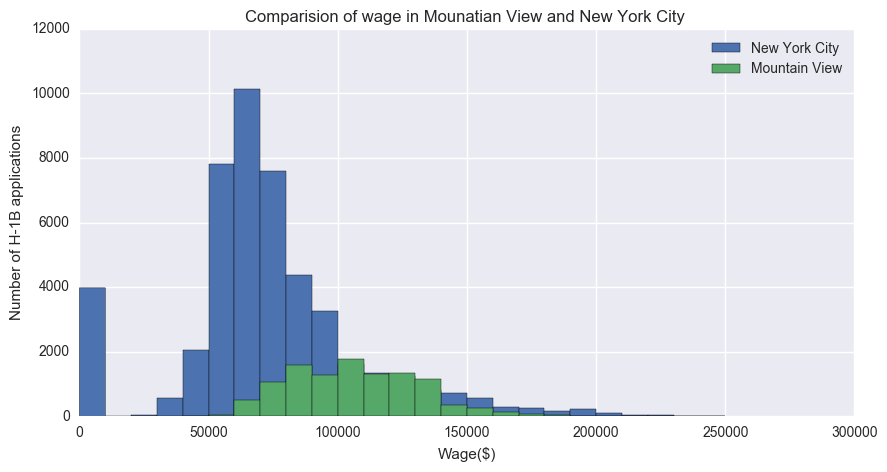

In [21]:
ax = plt.figure(figsize=(10,5)).add_subplot(1,1,1)

S = pd.DataFrame(generate_list(NY_wage)).dropna().rename(columns={0:"New York City"})["New York City"]
S_NY= S[~((S-S.mean()).abs()>3*S.std())]
#S_NY = S_NY[S_NY>20000]
S_NY.plot(kind="hist",bins= range(int(min(S_NY)), 250000 + 10000, 10000),label="New York City")
plt.xlabel("Wage($)")
plt.title("Waage in NYC")

#ax = plt.figure(figsize=(10,5)).add_subplot(2,2,2)

S = pd.DataFrame(generate_list(MV_wage)).dropna().rename(columns={0:"Mountain View"})["Mountain View"]
S_MV = S[~((S-S.mean()).abs()>3*S.std())]
S_MV.plot(ax = ax, kind="hist",bins= range(int(min(S_MV)), 250000 + 10000, 10000), label="Mountain View")
plt.xlabel("Wage($)")
plt.title("Comparision of wage in Mounatian View and New York City ")
plt.ylabel('Number of H-1B applications')

plt.legend()


### Two-sample t-test is used to investigate whether the means of two independent data samples differ from one another. In a two-sample test, the null hypothesis is that the means of both groups are the same. The test yields a p-value of 0.0, which means there is a 0% chance we'd see sample data this far apart if the two groups tested are actually identical. If we were using a 95% confidence level we  reject the null hypothesis, since the p-value is smaller than the corresponding significance level of 5%.

In [22]:
import scipy.stats as stats

stats.ttest_ind(a= S_MV,
                b= S_NY,
                equal_var=False) 

Ttest_indResult(statistic=112.89573550769721, pvalue=0.0)

### 3. For NYC, what is the relationship between the total number of H-1B visas requested by an employer and the average wages proposed? Visually represent this relationship if appropriate. Is the relationship statistically significant? What might explain this relationship?

In [23]:
# combine average wages with number of visa by each company
H1B_data_NYC_test_uni["mean_wage"] = (H1B_data_NYC_test_uni["lca_case_wage_rate_from"]\
                                                            *H1B_data_NYC_test_uni["total_workers"])\
                                                            /H1B_data_NYC_test_uni["total_workers"]

In [24]:
mean_wages = pd.DataFrame(H1B_data_NYC_test_uni.groupby("lca_case_employer_name")["mean_wage"].mean())
N_visa = pd.DataFrame(H1B_data_NYC.groupby("lca_case_employer_name")["total_workers"].sum())
N_visa = N_visa.rename(columns={"total_workers":"N_visa"})

In [25]:
merged_frame = pd.concat([mean_wages, N_visa], axis=1, join_axes=[mean_wages.index]).dropna()

In [26]:
merged_frame = merged_frame.rename(columns={"lca_case_wage_rate_from":"mean_wage"})

In [27]:
merged_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5932 entries, "I HAVE A DREAM" FOUNDATION to ZYPSEE, INC.
Data columns (total 2 columns):
mean_wage    5932 non-null float64
N_visa       5932 non-null float64
dtypes: float64(2)
memory usage: 139.0+ KB


In [28]:
norm_merged_frame = (merged_frame) / (merged_frame.max() - merged_frame.min())

In [29]:
norm_merged_frame.corr()

,mean_wage,N_visa
mean_wage,1.000000,0.002186
N_visa,0.002186,1.000000


In [30]:
max(merged_frame["N_visa"])

20298.0

In [31]:
from scipy import stats
#remove outliers
merge = merged_frame.copy()
rm_outlier = merge[(np.abs(stats.zscore(merge)) < 3).all(axis=1)]

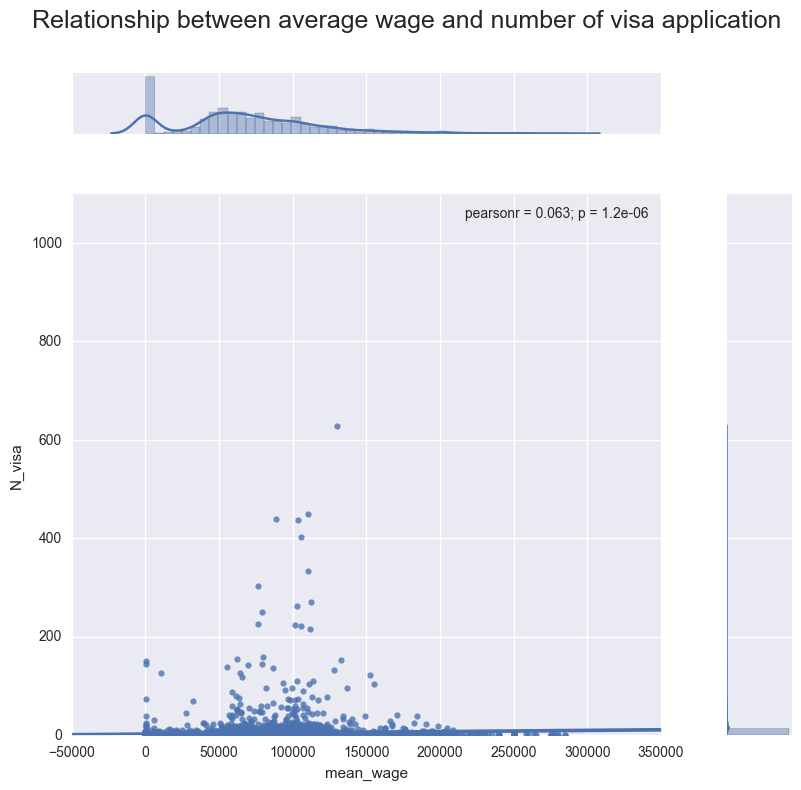

In [34]:
g = sns.jointplot("mean_wage","N_visa", data=rm_outlier, kind="reg", size=8, space=1)
plt.ylim(0,1100)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Relationship between average wage and number of visa application",fontsize=18)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 N_visa   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.05173
Date:                Mon, 05 Dec 2016   Prob (F-statistic):              0.950
Time:                        06:26:44   Log-Likelihood:                -41515.
No. Observations:                5932   AIC:                         8.304e+04
Df Residuals:                    5929   BIC:                         8.306e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               6.5753      5.821      1.130      0.259        -4.837    17.987
mean_wage            2.221e-05   7.05e-05      0.315      0.753        -0.000     0.000
I((mean_wage) ** 2) -1.394e-11   5.09e-11     -0.274      0.784     -1.14e-10  8.58e-11
==============================================================================
Omnibus:                    21613.624   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       8304450836.670
Skew:                          75.735   Prob(JB):                         0.00
Kurtosis:                    5797.449   Cond. No.                     1.68e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

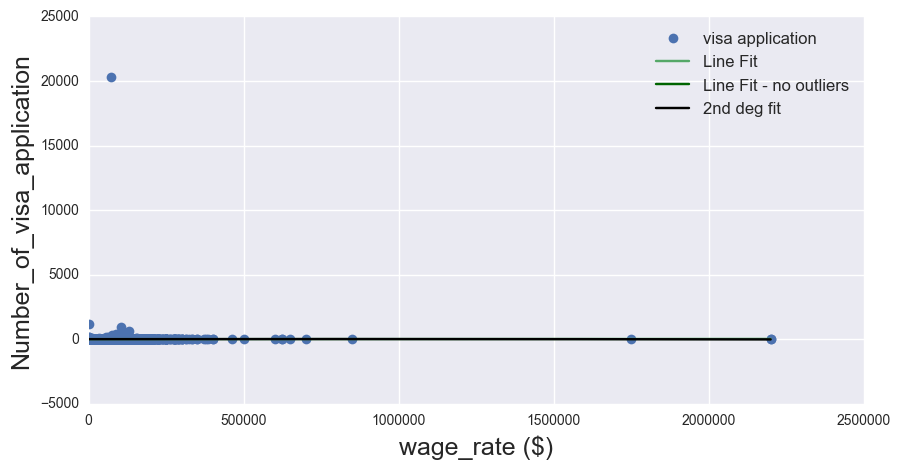

In [33]:


curvmodel14_N_visa = smf.ols(formula = "N_visa ~ mean_wage + I((mean_wage)**2)", data=merged_frame).fit()
linmodel2014 = smf.ols(formula = "N_visa ~ mean_wage", data = merged_frame).fit()
linmodel_cut2014 = smf.ols(formula = "N_visa ~ mean_wage", data = rm_outlier).fit()

ax = plt.figure(figsize=(10,5)).add_subplot(111)
ax.plot(merged_frame['mean_wage'], merged_frame['N_visa'], 'o', label="visa application")

ax.plot(np.linspace(merged_frame.mean_wage.min(), merged_frame.mean_wage.max(), 100), 
        linmodel2014.predict(exog = dict(mean_wage=np.linspace(merged_frame.mean_wage.min(),
                                                            merged_frame.mean_wage.max(),100))), label="Line Fit")
ax.plot(np.linspace(merged_frame.N_visa.min(), rm_outlier.N_visa.max(), 100), 
        linmodel_cut2014.predict(exog = dict(mean_wage=np.linspace(rm_outlier.mean_wage.min(), 
                                                        rm_outlier.mean_wage.max(),100))), 
        label="Line Fit - no outliers", color="DarkGreen")
ax.set_xlabel("wage_rate ($)", fontsize=18)
ax.set_ylabel("Number_of_visa_application", fontsize=18)

x = np.linspace(merged_frame.mean_wage.min(), merged_frame.mean_wage.max(), 1000)
ax.plot(x, curvmodel14_N_visa.predict(exog = dict(mean_wage=x)), '-', color="k", label="2nd deg fit")
ax.legend(fontsize=12, loc=1)
curvmodel14_N_visa.summary()

### the data shows that number of vias application is consistant in different visa application level. From the below figure shows that the correlation of two varaibles is not clear. I did both linear fit and 2 degree fit. The coefficient of p-value shows that they statistically different.
